In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

%matplotlib inline

### About this dataset
- **Age** : Age of the patient

- **Sex** : Sex of the patient

- **exang**: exercise induced angina (1 = yes; 0 = no)

- **ca**: number of major vessels (0-3)

- **cp** : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic

- **trestbps** : resting blood pressure (in mm Hg)

- **chol** : cholestoral in mg/dl fetched via BMI sensor

- **fbs** : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

- **restecg** : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- **thalach** : maximum heart rate achieved

- **target** : 0= less chance of heart attack 1= more chance of heart attack

In [196]:
heart = pd.read_csv('heart.csv')

# swap the heart attack condition, it suspected to be swapped from the source dataset
heart['target'] = heart['target'].apply(lambda x: 1 if x == 0 else 0)

# renaming the column header
heart.columns = ['Age', 
                 'Sex', 
                 'Chest Pain Type', 
                 'Resting Blood Pressure',
                 'Cholesterol',
                 'Fasting Blood Sugar', 
                 'Resting ECG', 
                 'Max. HR Acheived',
                 'Exercise Induced Angina', 
                 'ST Depression', 
                 'ST Slope', 
                 'Num. Major Blood Vessels', 
                 'Thalassemia', 
                 'Condition'
                ]

heart.head()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max. HR Acheived,Exercise Induced Angina,ST Depression,ST Slope,Num. Major Blood Vessels,Thalassemia,Condition
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [325]:
heart.describe()

,Age,Sex,Chest Pain Type,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max. HR Acheived,Exercise Induced Angina,ST Depression,ST Slope,Num. Major Blood Vessels,Thalassemia,Condition
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.455446
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,0.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
# converting the data types accordingly
categorical = heart.columns[heart.nunique()<=5]

for i in categorical:
    heart[i] = heart[i].astype("category")

heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
Age                         303 non-null int64
Sex                         303 non-null category
Chest Pain Type             303 non-null category
Resting Blood Pressure      303 non-null int64
Cholesterol                 303 non-null int64
Fasting Blood Sugar         303 non-null category
Resting ECG                 303 non-null category
Max. HR Acheived            303 non-null int64
Exercise Induced Angina     303 non-null category
ST Depression               303 non-null float64
ST Slope                    303 non-null category
Num. Major Blood Vessels    303 non-null category
Thalassemia                 303 non-null category
Condition                   303 non-null category
dtypes: category(9), float64(1), int64(4)
memory usage: 15.8 KB


**We don't have to worry about null value because none of the column has null value**

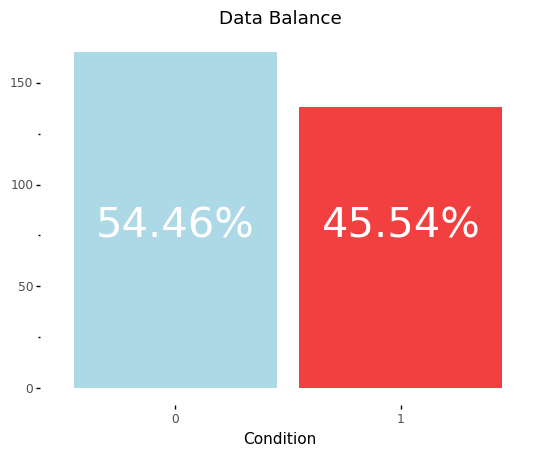

<ggplot: (-9223371931581298312)>

In [5]:
# checking data balance

(ggplot(heart)
 + aes(x = 'Condition', fill = 'Condition')
 + geom_bar(show_legend=False)
 + annotate('text', x=1, y = 80, 
            label="{:.2%}".format(heart.Condition.value_counts().iloc[0]/heart.Condition.value_counts().sum()), 
            color = 'white', size = 30)
 + annotate('text', x=2, y = 80, 
            label="{:.2%}".format(heart.Condition.value_counts().iloc[1]/heart.Condition.value_counts().sum()), 
            color = 'white', size = 30)
 + theme_bw()
 + theme(
    plot_background = element_blank(),
    panel_grid_major = element_blank(),
    panel_grid_minor = element_blank(),
    panel_border = element_blank(),
  )
 + labs(title = 'Data Balance', y = '')
 + scale_fill_manual(values = ("lightblue","#F24040"))
)

The dataset we have seems balanced.

However, heart attack is actually a somewhat rare diseases. This balanced dataset probably won't picture the realest condition of our world, therefore there may be an overestimation of heart attack probability on our machine learning model later.

In [6]:
# https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots-in-python

def kde_overlap_cal(parameter = 'Age'):
    x0 = heart.loc[heart['Condition'] == 0, str(parameter)]
    x1 = heart.loc[heart['Condition'] == 1, str(parameter)]

    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)

    xmin = min(x0.min(), x1.min())
    xmax = min(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    area_inters_x = np.trapz(inters_x, x)
    return(area_inters_x)

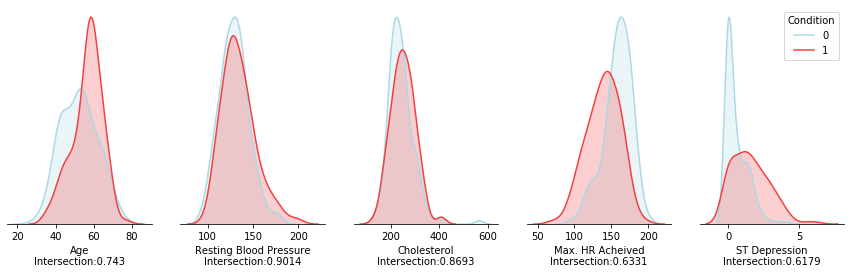

In [7]:
continuous = heart.select_dtypes(exclude = 'category').columns.tolist()

col = len(continuous)

fig,ax = plt.subplots(1,col,figsize = (15,4))

for i,j in zip(continuous, range(col)):
    overlap = str(round(kde_overlap_cal(i),4))
    
    g1 = sns.kdeplot(heart[i][heart['Condition'] == 0], ax=ax[j],color='lightblue', shade=True, legend = False)
    g1 = sns.kdeplot(heart[i][heart['Condition'] == 1], ax=ax[j],color='#F24040', shade=True, legend = False)
    g1.set_xlabel(i+'\nIntersection:'+overlap)
    g1.tick_params(left=False)
    g1.spines['top'].set_visible(False)
    g1.spines['left'].set_visible(False)
    g1.spines['right'].set_visible(False)
    g1.set(yticklabels=[])
    
plt.legend(title='Condition', loc='upper right', labels=[0, 1])

### Comment

From the graphs above, it seems that some of the parameters namely:
- Resting Blood Pressure
- Cholesterol

Can't easily distinguish between patient with high risk of heart attack. It is also supported by looking at their overlap between condition 1 and 0. Those 2 paramteres have the highest overlap, i.e. has no distinction between condition 1 and 2 throughout their values.

In [83]:
def cat_dif_cal(cat):
    temp_dict = {}
    for j in cat:
        temp = 0
        for i in heart[j].unique():
            temp = abs((len(heart[(heart['Condition'] == 1) & (heart[j] == i)]) - len(heart[(heart['Condition'] == 0) & (heart[j] == i)]))) + temp
        temp_dict[j] = temp
    return temp_dict

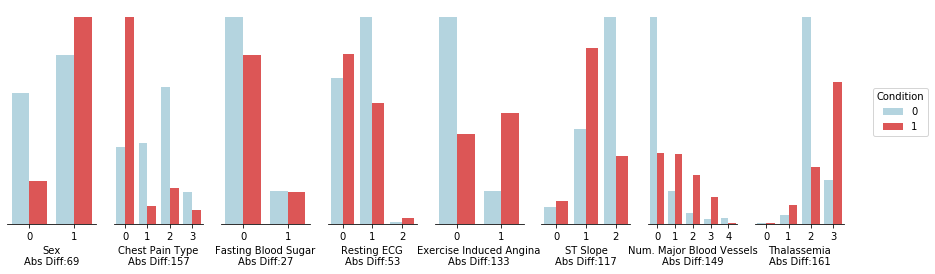

In [96]:
categorical = heart.select_dtypes(include = 'category').columns.tolist()
categorical.remove('Condition')

col2 = len(categorical)

dif = cat_dif_cal(categorical)

fig,ax = plt.subplots(1,col2,figsize = (15,4))

for i,j in zip(categorical, range(col2)):        
    g2 = sns.countplot(data = heart, x = i, ax = ax[j], hue = 'Condition', palette=['lightblue',"#F24040"])
    g2.set_ylabel('')
    g2.set_xlabel(i+'\nAbsolute Diff:'+str(dif[i]))
    g2.tick_params(left=False)
    g2.spines['top'].set_visible(False)
    g2.spines['left'].set_visible(False)
    g2.spines['right'].set_visible(False)
    g2.set(yticklabels=[])
    g2.legend([],[], frameon=False)

plt.legend(title='Condition', bbox_to_anchor=(1.5, 0.15, 0.5, 0.5), labels=[0, 1])

In [337]:
temp_df = pd.DataFrame(columns = ['x', 'y', 'cat'])
for k in continuous[0:-1]:
    for i in range(heart[k].min(), (heart[k].max())):
        temp_df.loc[len(temp_df)] = (i,
                                     sum(heart[(heart[k] <= i) & (heart['Condition'] == 1)][k].value_counts().values)/sum(heart[(heart[k] <= i)][k].value_counts().values),
                                     k)

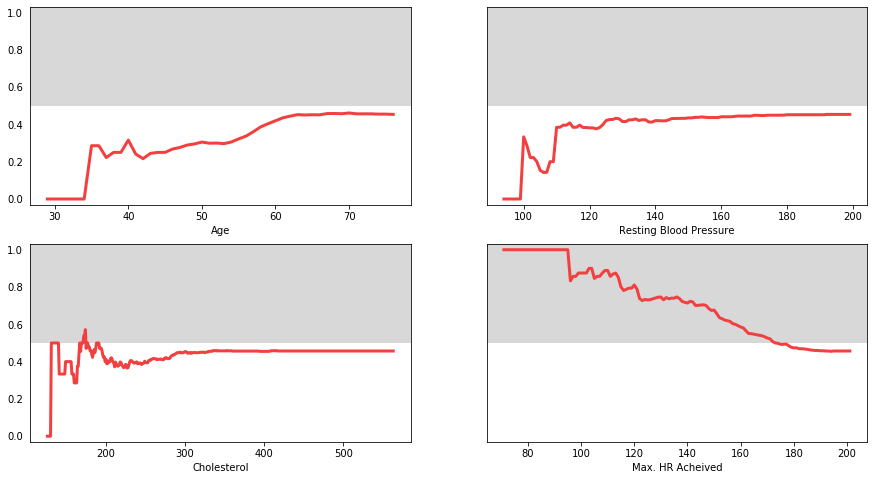

In [388]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (15,8),sharey=True)
for col, ax in zip(continuous[0:-1], ax.flatten()):
    g = sns.lineplot(data = temp_df[temp_df['cat'] == col], x = 'x', y = 'y', 
                     ax = ax, 
                     color = '#F24040', linewidth=3)
    g.set_ylim(-0.03,1.03)
    g.axhspan(0.5, 1.03, facecolor='grey', alpha=0.3)
    g.set_xlabel(col)
    g.set_ylabel('')
    g.tick_params(left=False)

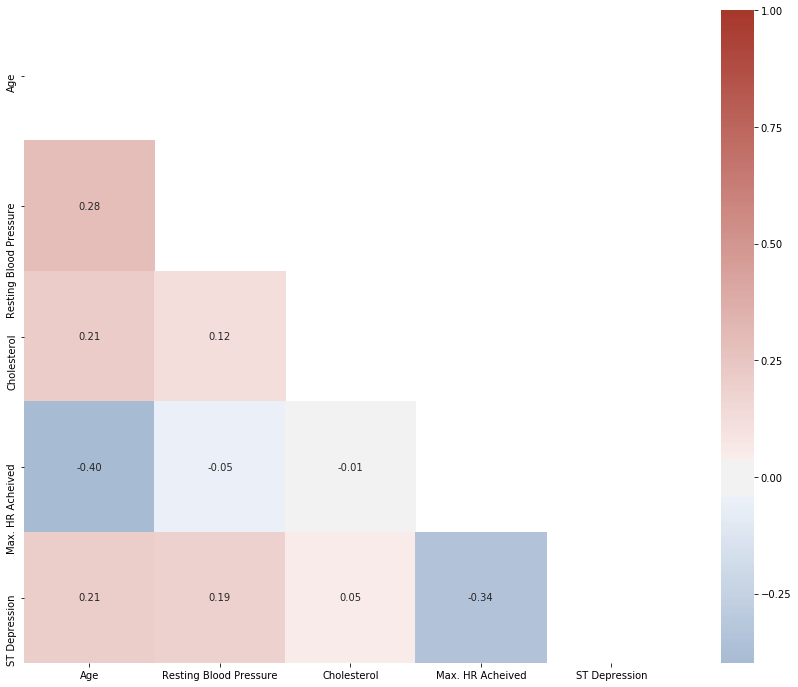

In [15]:
# https://www.kdnuggets.com/2021/04/awesome-tricks-best-practices-kaggle.html

# Calculate pairwise-correlation
matrix = heart.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

# plt.show();

## Machine Learning Part

In [ ]:
from sklearn.model_selection import train_test_split

# algos
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# these are the metrices will be used
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

In [ ]:
# Separating the features (X) and target (y)
# In this iteration, all features will be used

features = heart.columns.values.tolist()
features.remove('target')

X = heart[features]

y = heart['target']

# Split into train and validation
random_state = 1
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=random_state)

In [ ]:
# specify the model, first we will use random forest
# we will also check the best n estimator for the model
n_estimator = [10, 50, 100, 200, 500, 600]
max_leaf_node = [5, 25, 50, 100, 250, 500]

def get_mae(n_estimator, max_leaf_node, train_X, val_X, train_y, val_y):
    # specify model
    model = RandomForestClassifier(n_estimators = n_estimator, 
                                   max_leaf_nodes = max_leaf_node,
                                   random_state = random_state)
    
    # fit the model into training data
    model.fit(train_X, train_y)
    
    # make a prediction and calculate the MAE
    preds_val = model.predict(val_X)
    val_mae = mean_absolute_error(preds_val, val_y)
    
    return val_mae

In [ ]:
# make prediction using the validation data and calculate the MAE
rows_list = []
# mae_df = pd.DataFrame(columns = ['n_estimators','max_leaf_node','MAE'])
for i in n_estimator:
    for j in max_leaf_node:
        mae = get_mae(i,j, train_X, val_X, train_y, val_y)
        dict1 = {}
        dict1.update({'n_estimators':i,
                      'max_leaf_node':j,
                      'MAE':mae})
        rows_list.append(dict1)
        
mae_df = pd.DataFrame(rows_list)

In [ ]:
(ggplot(mae_df)
 + facet_grid(facets="~n_estimators")
 + aes(x = 'max_leaf_node', y = 'MAE')
 + labs(title = 'n_estimators and max_leaf_node \nbehaviour to MAE', y="MAE")
 + geom_line(color = 'blue')
 + theme(figure_size=(10, 4))
)

In [ ]:
print("n_estimator with lowest MAE:",mae_df[mae_df['MAE'] == mae_df['MAE'].min()].n_estimators.values[0])
print("max_leaf_node with lowest MAE:",mae_df[mae_df['MAE'] == mae_df['MAE'].min()].max_leaf_node.values[0])

In [ ]:
param_grid = {'n_estimators': n_estimator, 
              'max_leaf_nodes': max_leaf_node,
              'max_features': ['auto', 'sqrt'], 
              'bootstrap': [True, False], 
              'criterion':['entropy', 'gini']}

rfcgrid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, verbose=100, cv=10, n_jobs=-2)
rfcgrid.fit(train_X, train_y)

In [ ]:
rfcgrid.best_params_

In [ ]:
get_mae(600,25,train_X, val_X, train_y, val_y)